In [254]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.preprocessing import LabelEncoder, RobustScaler

In [282]:
# !pip install scikit-learn pandas numpy
# !pip install matplotlib seaborn
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 5.4 MB/s eta 0:00:0000:0100:01


In [169]:
data = './PS_20174392719_1491204439457_log.csv'
colsTypes = {
'step':            np.int8,
'type':            object,
'amount':         np.float32,
'nameOrig':        object,
'oldbalanceOrg':  np.float32,
'newbalanceOrig': np.float32,
'nameDest':        object,
'oldbalanceDest': np.float32,
'newbalanceDest': np.float32,
'isFraud':          np.int8,
}
# The column 'isFlaggedFraud' has been dropped from the df DataFrame
df = pd.read_csv(data, dtype=colsTypes, usecols=[0,1,2,3,4,5,6,7,8,9])
# df, df_other = train_test_split(df, test_size=0.90, random_state=11)

The below column reference:
------------------------------------
- step: represents a unit of time where 1 step equals 1 hour
- type: type of online transaction
- amount: the amount of the transaction
- nameOrig: customer starting the transaction
- oldbalanceOrg: balance before the transaction
- newbalanceOrig: balance after the transaction
- nameDest: recipient of the transaction
- oldbalanceDest: initial balance of recipient before the transaction
- newbalanceDest: the new balance of recipient after the transaction
- isFraud: fraud transaction

In [170]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.000000,C840083671,181.0,0.000000,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.0,0


In [171]:
df.dtypes

step                 int8
type               object
amount            float32
nameOrig           object
oldbalanceOrg     float32
newbalanceOrig    float32
nameDest           object
oldbalanceDest    float32
newbalanceDest    float32
isFraud              int8
dtype: object

In [172]:
df.type.value_counts()

payment_type_map = {
    1: 'CASH_OUT',
    2: 'PAYMENT',
    3: 'CASH_IN',
    4: 'TRANSFER',
    5: 'DEBIT'
}

## EDA
- check max values
- check data values ranges
- check value counts

In [173]:
#Define custom colors
light_orange = '#ffd699'
light_red = '#ff9999'

In [174]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

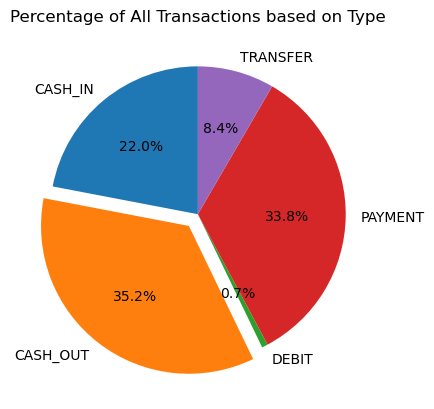

<Figure size 600x600 with 0 Axes>

In [175]:
all_counts_by_type = df.groupby("type").size()
plt.pie(all_counts_by_type, labels=all_counts_by_type.index, autopct='%1.1f%%', startangle=90, explode=(0, 0.1, 0, 0, 0))
plt.title('Percentage of All Transactions based on Type')
plt.figure(figsize=(6, 6))
plt.show()

In [176]:
fraudTrans_count = df[df["isFraud"] == 1].shape[0]
non_fraudTrans_count = df[df["isFraud"] == 0].shape[0]

print(f"Count of Fraud Transactions: {f'{fraudTrans_count:,.0f}'}")
print(f"Count of Non-fraud Transactions: {f'{non_fraudTrans_count:,.0f}'}")

Count of Fraud Transactions: 8,213
Count of Non-fraud Transactions: 6,354,407


In [177]:
total_transactions = fraudTrans_count + non_fraudTrans_count

fraud_percentage = (fraudTrans_count / total_transactions) * 100
non_fraud_percentage = (non_fraudTrans_count / total_transactions) * 100

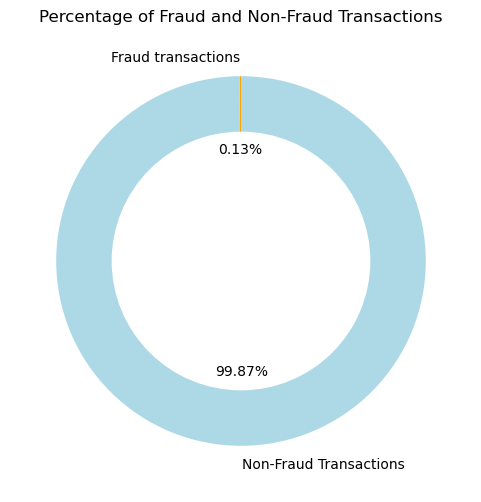

In [178]:
labels = ['Fraud transactions', 'Non-Fraud Transactions']
sizes = [fraud_percentage, non_fraud_percentage]
colors = ['orange', 'lightblue']

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90, colors=colors)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

plt.title('Percentage of Fraud and Non-Fraud Transactions')
plt.show()

## >> This indicate clearly the class imbalance in this dataset.

In [179]:
fraud_transactions = df[df["isFraud"] == 1]
fraud_transactions_counts_by_type = fraud_transactions.groupby("type").size()
print(fraud_transactions_counts_by_type)

type
CASH_OUT    4116
TRANSFER    4097
dtype: int64


**All the fraud transations are exclusive to type of ['CASH_OUT', 'TRANSFER']**

In [180]:
df.describe().round()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6362620.0,6362620.0,6362620.0,6362620.0,6362620.0,6362620.0,6362620.0
mean,-5.0,179862.0,833883.0,855114.0,1100702.0,1224997.0,0.0
std,73.0,603858.0,2888242.0,2924048.0,3399180.0,3674129.0,0.0
min,-128.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-72.0,13390.0,0.0,0.0,0.0,0.0,0.0
50%,8.0,74872.0,14208.0,0.0,132706.0,214661.0,0.0
75%,46.0,208721.0,107315.0,144258.0,943037.0,1111909.0,0.0
max,127.0,92445520.0,59585040.0,49585040.0,356015904.0,356179264.0,1.0


## 2.Data Preprocessing
- check missing values
- map categorical values if any

In [181]:
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [182]:
df[df['amount'] == 0]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
2736447,-44,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.000000e+00,0.000000e+00,1
3247298,-6,CASH_OUT,0.0,C521393327,0.0,0.0,C480398193,0.000000e+00,0.000000e+00,1
3760289,23,CASH_OUT,0.0,C539112012,0.0,0.0,C1106468520,5.385476e+05,5.385476e+05,1
5563714,-125,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7.970766e+06,7.970766e+06,1
5996408,-87,CASH_OUT,0.0,C832555372,0.0,0.0,C1462759334,7.675990e+04,7.675990e+04,1
5996410,-87,CASH_OUT,0.0,C69493310,0.0,0.0,C719711728,2.921531e+06,2.921531e+06,1
6168500,42,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,2.302897e+05,2.302897e+05,1
6205440,74,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1.328473e+06,1.328473e+06,1
6266414,105,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.000000e+00,0.000000e+00,1
6281483,-122,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.000000e+00,0.000000e+00,1


> **According to the previuos analysis there's high anamoly within CASH_OUT and TRANSFER transactions indicates that these specific types may be more prone to fraudul activities**

In [183]:
processed_df = df[~df['type'].isin(['DEBIT', 'PAYMENT', 'CASH_IN',])]

In [184]:
print(f"Total transactions for CASH_OUT, TRANSFER count: {processed_df.shape[0]}")

Total transactions for CASH_OUT, TRANSFER count: 2770409


A considerable number of balances in our dataset appear to be inaccurate. This suggests that a significant portion of transactions might have inconsistencies in their origin and destination balances.



In [185]:
processed_df.loc[ (processed_df["oldbalanceOrg"] == 0) | (processed_df["oldbalanceOrg"] < processed_df["amount"]), "oldbalanceOrg"] = processed_df["amount"]
processed_df["newbalanceOrig"] = processed_df["oldbalanceOrg"] - processed_df["amount"]
processed_df["newbalanceDest"] = processed_df["oldbalanceDest"] + processed_df["amount"]

/tmp/ipykernel_6425/2262409280.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df["newbalanceOrig"] = processed_df["oldbalanceOrg"] - processed_df["amount"]
/tmp/ipykernel_6425/2262409280.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df["newbalanceDest"] = processed_df["oldbalanceDest"] + processed_df["amount"]


> **NEW COLUMN ADDED (C2C)** This column is formed according to these two columns: ['nameOrg', 'nameDest'] if start with the letter 'C' => indicate it's a Customer to Customer transation

In [186]:
processed_df['isC2C'] = ((processed_df['nameOrig'].str.startswith('C').astype('int8') == 1) & (processed_df['nameDest'].str.startswith('C').astype(int) == 1)).astype(int)

/tmp/ipykernel_6425/3714454422.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['isC2C'] = ((processed_df['nameOrig'].str.startswith('C').astype('int8') == 1) & (processed_df['nameDest'].str.startswith('C').astype(int) == 1)).astype(int)


**TWO COLUMNS DELETED**
> As they are not relevant to the target variable predication [nameDest, nameOrig]

In [187]:
processed_df.drop(columns=['nameDest', 'nameOrig'], axis=1, inplace=True)

/tmp/ipykernel_6425/4137816100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df.drop(columns=['nameDest', 'nameOrig'], axis=1, inplace=True)


In [192]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2770409 entries, 2 to 6362619
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            float16
 1   type            int64  
 2   amount          float32
 3   oldbalanceOrg   float32
 4   newbalanceOrig  float32
 5   oldbalanceDest  float32
 6   newbalanceDest  float32
 7   isFraud         int8   
 8   isC2C           int64  
dtypes: float16(1), float32(5), int64(2), int8(1)
memory usage: 188.7 MB


**2.1.3 Transform categorical columns to numerical**

In [193]:
label_encoder = LabelEncoder()
processed_df['type'] = label_encoder.fit_transform(processed_df['type'])

/tmp/ipykernel_6425/2438025859.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['type'] = label_encoder.fit_transform(processed_df['type'])


In [194]:
numeric_columns = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

In [195]:
for column in numeric_columns:
    processed_df[column] = np.log1p(processed_df[column])

robust_scaler = RobustScaler()
processed_df[numeric_columns] = robust_scaler.fit_transform(processed_df[numeric_columns])

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_6425/1807394660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df[column] = np.log1p(processed_df[column])
/tmp/ipykernel_6425/1807394660.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df[numeric_columns] = robust_scaler.fit_transform(processed_df[numeric_columns])


> The **RobustScaler** is employed to scale features based on the interquartile range (IQR), ensuring robustness to outliers. This scaler is particularly beneficial when dealing with data that contains outliers, as it leverages the median and IQR for scaling rather than the mean and standard deviation.



### Check the target class distribution

In [196]:
fraudTrans_count = processed_df[processed_df["isFraud"] == 1].shape[0]
non_fraudTrans_count = processed_df[processed_df["isFraud"] == 0].shape[0]

print(f"Count of Fraud Transactions: {f'{fraudTrans_count:,.0f}'}")
print(f"Count of Non-fraud Transactions: {f'{non_fraudTrans_count:,.0f}'}")

Count of Fraud Transactions: 8,213
Count of Non-fraud Transactions: 2,762,196


### 2.2 Data Splitting

In [197]:
df_full_train, df_test = train_test_split(processed_df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [198]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [199]:
y_train = (df_train.isFraud).astype('int').values
y_val = (df_val.isFraud).astype('int').values
y_test = (df_test.isFraud).astype('int').values

Removing target variable column from the dataset

In [200]:
del df_train['isFraud']
del df_val['isFraud']
del df_test['isFraud']

In [201]:
df_train

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isC2C
0,0.484642,1,0.821101,0.810444,0.000000,-14.284499,-0.237112,1
1,-2.136519,1,0.849588,0.840708,0.000000,0.489806,0.622042,1
2,0.672355,1,-0.510309,-0.604061,0.000000,0.994941,1.251635,1
3,NaN,0,0.652529,0.631351,0.000000,-0.046838,0.057713,1
4,0.621160,0,0.562886,0.536113,0.000000,0.078931,0.136912,1
...,...,...,...,...,...,...,...,...
1662240,NaN,0,-0.380171,-0.449364,2.156259,-0.388223,-0.536729,1
1662241,NaN,0,-0.597105,-0.696274,0.000000,-14.284499,-1.363348,1
1662242,0.662116,0,0.283869,0.239682,0.000000,-0.274833,-0.241902,1
1662243,NaN,0,0.149998,0.097456,0.000000,-0.139711,-0.171497,1


3.Training
-------------

### 3.1 Decision Tree

In [202]:
train_dicts = df_train.to_dict(orient='records')

In [203]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [204]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [205]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [206]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7568908860833502

In [207]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.8400975956004106

### 3.1.1 Restrict max depth of the decision tree

In [232]:
dt = DecisionTreeClassifier(max_depth=6)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6)

In [233]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.8686520072213043
val: 0.857946659360263


In [210]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- amount <= 1.87
|   |--- oldbalanceDest <= -14.26
|   |   |--- step <= 0.12
|   |   |   |--- oldbalanceOrg <= -7.62
|   |   |   |   |--- class: 1
|   |   |   |--- oldbalanceOrg >  -7.62
|   |   |   |   |--- class: 0
|   |   |--- step >  0.12
|   |   |   |--- class: 0
|   |--- oldbalanceDest >  -14.26
|   |   |--- oldbalanceOrg <= 0.96
|   |   |   |--- amount <= -25.43
|   |   |   |   |--- class: 1
|   |   |   |--- amount >  -25.43
|   |   |   |   |--- class: 0
|   |   |--- oldbalanceOrg >  0.96
|   |   |   |--- type <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- type >  0.50
|   |   |   |   |--- class: 0
|--- amount >  1.87
|   |--- type <= 0.50
|   |   |--- step <= 0.66
|   |   |   |--- amount <= 1.94
|   |   |   |   |--- class: 1
|   |   |   |--- amount >  1.94
|   |   |   |   |--- class: 1
|   |   |--- step >  0.66
|   |   |   |--- class: 1
|   |--- type >  0.50
|   |   |--- amount <= 3.29
|   |   |   |--- oldbalanceDest <= -11.21
|   |   |   |   |--- class: 0
|   |   | 

### Decision tree hyperparamters tuning
- MAX_DEPTH
- MIN_SAMPLES_LEAF

In [239]:
for depth in [1,2,3,4,5,6,8, None]:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%4s --> %.3f' % (depth, auc))
#     print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

   1 --> 0.503
   2 --> 0.757
   3 --> 0.862
   4 --> 0.793
   5 --> 0.850
   6 --> 0.828
   8 --> 0.821
None --> 0.775


### 3.1.2 Try different params combinations

In [242]:
scores = []
for depth in [3,4,5,6]:
    for min_sample in [1,2,5,15,20,100,1000,10000,50000,100000]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=min_sample)
        dt.fit(X_train, y_train)
    
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((depth, min_sample, auc))
        print('[%4s, %6d] --> %.3f' % (depth, min_sample, auc))


[   3,      1] --> 0.800
[   3,      2] --> 0.782
[   3,      5] --> 0.859
[   3,     15] --> 0.780
[   3,     20] --> 0.772
[   3,    100] --> 0.791
[   3,   1000] --> 0.803
[   3,  10000] --> 0.793
[   3,  50000] --> 0.796
[   3, 100000] --> 0.771
[   4,      1] --> 0.835
[   4,      2] --> 0.830
[   4,      5] --> 0.790
[   4,     15] --> 0.794
[   4,     20] --> 0.814
[   4,    100] --> 0.804
[   4,   1000] --> 0.806
[   4,  10000] --> 0.811
[   4,  50000] --> 0.797
[   4, 100000] --> 0.815
[   5,      1] --> 0.834
[   5,      2] --> 0.835
[   5,      5] --> 0.832
[   5,     15] --> 0.857
[   5,     20] --> 0.834
[   5,    100] --> 0.847
[   5,   1000] --> 0.806
[   5,  10000] --> 0.796
[   5,  50000] --> 0.802
[   5, 100000] --> 0.792
[   6,      1] --> 0.814
[   6,      2] --> 0.828
[   6,      5] --> 0.799
[   6,     15] --> 0.851
[   6,     20] --> 0.818
[   6,    100] --> 0.783
[   6,   1000] --> 0.847
[   6,  10000] --> 0.827
[   6,  50000] --> 0.775
[   6, 100000] --> 0.795


In [247]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns = columns)
df_scores.head()

,max_depth,min_samples_leaf,auc
0,3,1,0.800243
1,3,2,0.782124
2,3,5,0.858546
3,3,15,0.780257
4,3,20,0.771771


In [253]:
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,min_samples_leaf,auc
2,3,5,0.858546
23,5,15,0.856601
33,6,15,0.850696
25,5,100,0.847336
36,6,1000,0.846816


In [252]:
df_scores_pivot = df_scores.pivot(index= 'min_samples_leaf', columns= ['max_depth'], values=['auc'])
df_scores_pivot

auc                              
max_depth                3         4         5         6
min_samples_leaf                                        
1                 0.800243  0.835123  0.834234  0.813566
2                 0.782124  0.829618  0.835180  0.827902
5                 0.858546  0.790197  0.832024  0.798681
15                0.780257  0.793932  0.856601  0.850696
20                0.771771  0.814112  0.833523  0.818242
100               0.791497  0.803914  0.847336  0.783436
1000              0.803368  0.805931  0.805767  0.846816
10000             0.792589  0.811078  0.796393  0.827383
50000             0.795577  0.797321  0.801935  0.774524
100000            0.770869  0.814862  0.792486  0.794626

### Visualise the best hyperparamters for training Decision Tree aganist the prediction accuracy

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

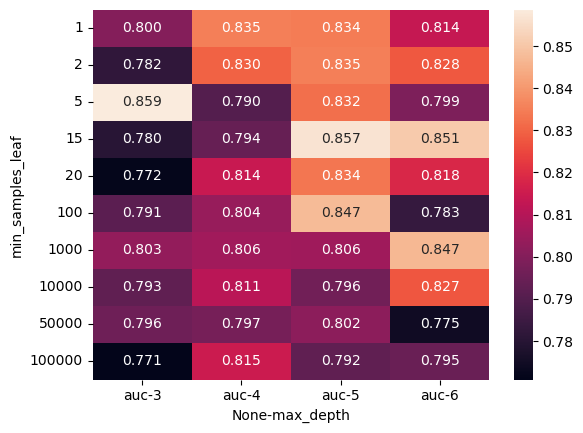

In [251]:
sns.heatmap(df_scores_pivot, annot= True, fmt='.3f')

### 3.2 Random Forest model

In [ ]:
randomForest_scores = []
for n in range(10, 201, 10):
    randomForest = RandomForestClassifier(n_estimators= n, random_state= 1)
    randomForest.fit(X_train, y_train)
    
    y_pred = randomForest.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    randomForest_scores.append((n, auc))

In [ ]:
columns = ['n_estimators', 'auc']
df_scores = pd.DataFrame(randomForest_scores, columns = columns)
df_scores.head()

In [ ]:
plt.plot(df_scores.n_estimators, df_scores.auc)

### 3.2.1 Tune Random forest model hyperparamters

### 3.2.1.a Tune max_depth param

In [261]:
randomForest_scores = []

for depth in [6]:
    for n in range(10, 201, 20):
        randomForest = RandomForestClassifier(n_estimators= n,max_depth= depth, random_state= 1)
        randomForest.fit(X_train, y_train)

        y_pred = randomForest.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        randomForest_scores.append((depth, n, auc))
        print('[%4s, %6d] --> %.3f' % (depth, n, auc))


[   6,     10] --> 0.862
[   6,     30] --> 0.873
[   6,     50] --> 0.873
[   6,     70] --> 0.874
[   6,     90] --> 0.874
[   6,    110] --> 0.874
[   6,    130] --> 0.874


KeyboardInterrupt: 

In [266]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(randomForest_scores, columns = columns)
df_scores.head()

,max_depth,n_estimators,auc
0,4,10,0.853636
1,4,30,0.870171
2,4,50,0.870056
3,4,70,0.870606
4,4,90,0.869192


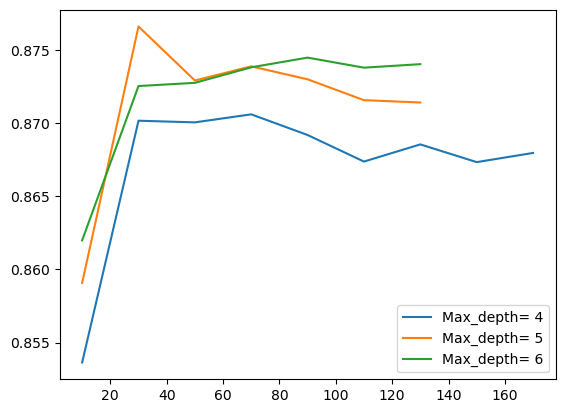

In [267]:
for depth in [4,5,6]:
    df_subset = df_scores[df_scores.max_depth == depth]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='Max_depth= %d' % depth)
plt.legend()

In [273]:
randomForest_scores = []
best_max_depth = 6
min_samples_leaf_values = [1, 3, 5, 10];

for min_sample in min_samples_leaf_values:
    for n in range(10, 101, 20):
        randomForest = RandomForestClassifier(n_estimators= n,
                                              max_depth= best_max_depth,
                                              min_samples_leaf=min_sample,
                                              random_state= 1,
                                             n_jobs= -1)
        randomForest.fit(X_train, y_train)

        y_pred = randomForest.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        randomForest_scores.append((min_sample, n, auc))
        print('[%2s, %6d] --> %.3f' % (min_sample, n, auc))


### 3.2.1.b Tune min_samples_leaf param

In [274]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(randomForest_scores, columns = columns)
df_scores.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.861991
1,1,30,0.872542
2,1,50,0.872760
3,1,70,0.873822
4,1,90,0.874485


In [277]:
df_scores

,min_samples_leaf,n_estimators,auc
0,1,10,0.861991
1,1,30,0.872542
2,1,50,0.872760
3,1,70,0.873822
4,1,90,0.874485
5,1,110,0.873798
6,1,130,0.874038
7,1,150,0.873127
8,3,10,0.867066
9,3,30,0.873089


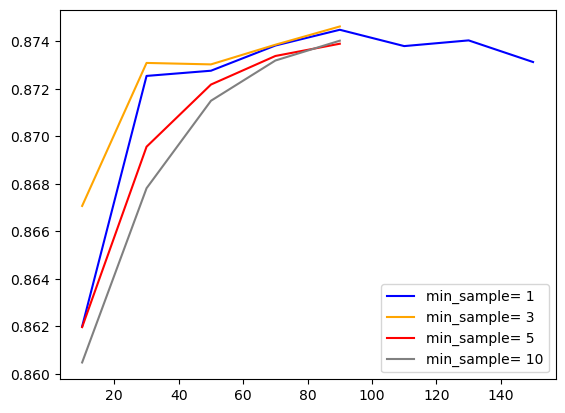

In [278]:
colors = ['blue', 'orange', 'red', 'grey']
list(zip(min_samples_leaf_values, colors))


for min_sample, color in zip(min_samples_leaf_values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == min_sample]
    plt.plot(df_subset.n_estimators,
             df_subset.auc,
             color= color,
             label='min_sample= %d' % min_sample)
plt.legend()

### 3.2.2 Best Random forest model Hyperparamters

In [279]:
best_n_estimators = 90
best_min_samples = 3
randomForest = RandomForestClassifier(n_estimators= best_n_estimators,
                                      max_depth= best_max_depth,
                                      min_samples_leaf=best_n_estimators,
                                      random_state= 1,
                                     n_jobs= -1)
randomForest.fit(X_train, y_train)

y_pred = randomForest.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)

In [280]:
auc

0.8721236539604182

### 3.3 XGBoost model

In [283]:
import xgboost as xgb

In [290]:
features = dv.get_feature_names_out().tolist()
dtrain = xgb.DMatrix(X_train, label= y_train, feature_names= features)
dval = xgb.DMatrix(X_val, label= y_val, feature_names= features)

watchlist = [(dtrain, 'train'), (dval, 'val')]

### 3.3.1 Monitoring XGB performance

In [347]:
def parse_xgb_output(output):
    results = []
    
    for line in output.stdout.strip().split('\n'):
        num_iter, train_line, val_line =  line.split('\t')
        iteration = int(num_iter.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((iteration, train, val))
    columns = ['num_iteration', 'train_auc', 'val_auc']
    
    df_results = pd.DataFrame(results, columns= columns)
    return df_results

In [348]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthreads': 4,
    'seed': 1,
    'verbosity': 1,
    
}
model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round= 10)

In [349]:
roc_auc_score(y_val, y_pred)

0.8832158991505019

In [328]:
df_score = parse_xgb_output(output)

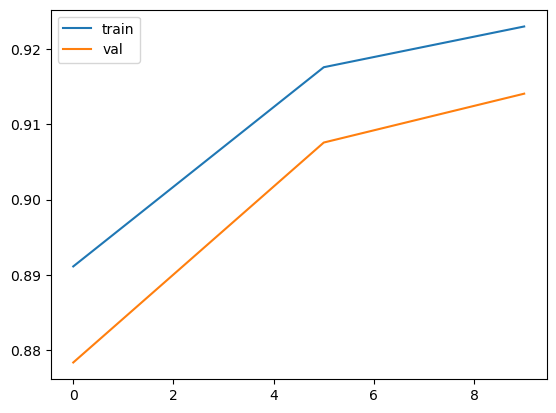

In [329]:
plt.plot(df_score.num_iteration, df_score.train_auc, label='train')
plt.plot(df_score.num_iteration, df_score.val_auc, label='val')
plt.legend()

### 3.3.2 Tuning XGBoost hyperparameters
- eta
- max_depth
- min_child_weight

### 3.3.2.a ETA learning rate tuning

In [380]:
%%capture output

eta_values = [3.0, 0.05, 0.01, 0.001]
# xgb_scores= {}

xgb_params['eta'] = eta_values[3]
model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round= 100)
y_pred = model.predict(dval)
xgb_scores['eta=%s' % eta_values[3]] = parse_xgb_output(output)

# for eta in eta_values:


    

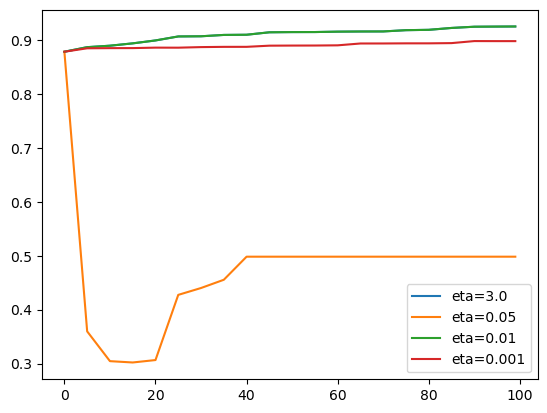

In [381]:
for eta_value in eta_values:
    df_score = xgb_scores['eta=%s' % eta_value]
    plt.plot(df_score.num_iteration, df_score.val_auc, label='eta=%s' % eta_value)
plt.legend()
    

### 3.3.2.b Max_depth tuning

In [392]:
%%capture output

xgb_params['eta'] = 0.01
depth_values = [3, 4, 6]

# xgb_scores= {}
# for depth in depth_values:
xgb_params['max_depth'] = depth_values[2]
model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round= 100)

y_pred = model.predict(dval)
xgb_scores['depth=%s' % depth_values[2]] = parse_xgb_output(output)

    

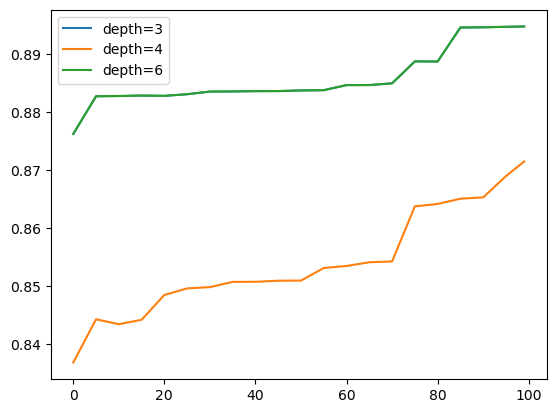

In [393]:
for depth in depth_values:
    df_score = xgb_scores['depth=%s' % depth]
    plt.plot(df_score.num_iteration, df_score.val_auc, label='depth=%s' % depth)
plt.legend()
    

### 3.3.2.c Min_child_weight tuning

In [412]:
%%capture output

xgb_params['max_depth'] = 6
min_child_values = [1, 10, 30]

xgb_scores= {}
# for depth in depth_values:
xgb_params['min_child_weight'] = min_child_values[1]
model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round= 200)

y_pred = model.predict(dval)
xgb_scores['min_child_weight=%s' % min_child_values[1]] = parse_xgb_output(output)

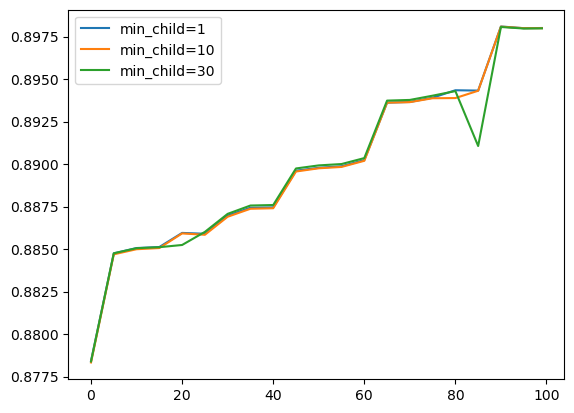

In [407]:
for min_child in min_child_values:
    df_score = xgb_scores['min_child_weight=%s' % min_child]
    plt.plot(df_score.num_iteration, df_score.val_auc, label='min_child=%s' % min_child)
plt.legend()
    

### 3.3.3 Best XGBoost Model hyperparamters

In [440]:
%%capture output

xgb_scores= {}

xgb_params['max_depth'] = 6
xgb_params['eta'] = 0.01
xgb_params['min_child_weight'] = 10
model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round= 200)
y_pred = model.predict(dval)
xgb_scores['min_child_weight=10'] = parse_xgb_output(output)



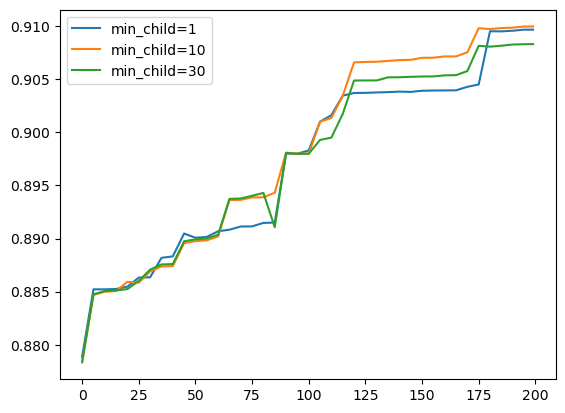

In [441]:
df_score_1 = xgb_scores['min_child_weight=1']
df_score_10 = xgb_scores['min_child_weight=10']
df_score_30 = xgb_scores['min_child_weight=30']

# plt.plot(df_score_1.num_iteration, df_score_1.val_auc, label='min_child=1')
plt.plot(df_score_10.num_iteration, df_score_10.val_auc, label='min_child=10')
# plt.plot(df_score_30.num_iteration, df_score_30.val_auc, label='min_child=30')

plt.legend()

## 4.Final best auc score is the best for XGBoost model
- max_depth = 6
- eta = 0.01
- min_child_weight = 10

In [445]:
parse_xgb_output(output).sort_values(by='val_auc', ascending=False).iloc[0]

num_iteration    199.00000
train_auc          0.91925
val_auc            0.90996
Name: 40, dtype: float64